# Calculate error distribution across stimuli 

In [212]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings("ignore", message="genfromtxt")

N_SUBJECTS = 339
subjects = range(N_SUBJECTS)
HCP_DIR = '.'
bold_run = ["tfMRI_WM_RL", "tfMRI_WM_LR"]

## Helper function

In [213]:
def mask_subs_no_error(files_oI, subjects, HCP_DIR, bold_run):
    
    """Get list of subject with 0 errors in at least one condition 
       in task.

    Args:
      files_oI (list of strings) : list of condition .txt files to check ()
      subjects (list of int) : subjects t
      HCP_DIR(str): directory path
      bold_run(list): list of bold_runs ("tfMRI_WM_RL", "tfMRI_WM_LR")      
      
    Returns:
       2x excl_subs_**** (tuple) : list of unique subjects

    """

    warnings.filterwarnings("ignore", message="genfromtxt")


    files_oI = files_oI        #currently ['2bk_err.txt', '2bk_nlr.txt']

    excl_subs_tfMRI_WM_RL = [] ##initialize list per task 
    excl_subs_tfMRI_WM_LR = []
    

    for t in bold_run: # iterate over task and subjects

        for sub in subjects:

            path = HCP_DIR + "/subjects/{}/EVs/{}".format(sub,t) #set path
            files = os.listdir(path)
            files = [file for file in files if file in files_oI] # choose files of interest from path

            for file in files:
                f = np.genfromtxt(path + "/" + file)

                if f.size == 0: # check for empty files in specific task
                    if t == "tfMRI_WM_RL":
                        excl_subs_tfMRI_WM_RL.append(sub) # append to respective list 
                    else:
                        excl_subs_tfMRI_WM_LR.append(sub)
                        
    #print(len(list(set(excl_subs_tfMRI_WM_RL)))) ###sanity check
    #print(len(list(set(excl_subs_tfMRI_WM_LR))))                    

    # return unique subjects per task, hint: if files_oI contains > 1 condition, doubles are possible  
    return (list(set(excl_subs_tfMRI_WM_RL)), list(set(excl_subs_tfMRI_WM_LR)))


def return_X_sorted(HCP_DIR, subject, task_key):
    '''Loads _cor.txt and _err.txt files, concatenates and sorts after time
    
    Args:
    - HCP_DIR (str)  : path of directory 
    - subject (int)  : current subject 
    - task_key(str)  : task key of current task
    
    Returns: 
    - X (np.ndarray) : 80x2 ndarray with columns time stamp and errors (1 = error)
    '''
    corr = np.genfromtxt(f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/all_bk_cor.txt")
    err =  np.genfromtxt(f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/all_bk_err.txt")
    corr = np.hstack((corr[:,0].reshape(-1,1), np.zeros_like(corr[:,0].reshape(-1,1))))
    if err.size == 3: 
        err = err[np.newaxis, :]
        err = np.hstack((err[:,0].reshape(-1,1), np.ones_like(err[:,0]).reshape(-1,1)))
        X = np.vstack((corr, err))
        X = X[X[:,0].argsort()]
    elif err.size == 0: 
        X = corr
    else: 
        err = np.hstack((err[:,0].reshape(-1,1), np.ones_like(err[:,0]).reshape(-1,1)))
        X = np.vstack((corr, err))
        X = X[X[:,0].argsort()]
    return X 

## Function error distribution stimulus

In [214]:
def error_distribution_stimulus(subjects, HCP_DIR):
    '''Returns distribution of errors across stimuli 
    Args: 
    - subjects (tuples):     list of subjects
    - HCP_DIR (str)  :       path of directory 
    - task_key(str)  :       task key of current task   
    
    Returns: 
    - cum_err (nd.array, 1x16):  errors across stimuli     
    '''
    stimuli = ['faces', 'body', 'tools', 'places']
    task_keys = ["tfMRI_WM_RL", "tfMRI_WM_LR"]
    errortypes = ['0bk_', '2bk_']
    cue_duration = 2.565
    len_block = 10
    cum_err = np.zeros([len(subjects), 16])
    #print(subjects)
    for subject in subjects:
        #print(subject)
        for task_key in task_keys:
            #print(task_key)
            X = return_X_sorted(HCP_DIR=HCP_DIR, subject=subject, task_key=task_key)
            A = X
            if task_key == 'tfMRI_WM_RL':
                help_I_need_somebody = 0
            else:
                help_I_need_somebody = 8
            for idx, errortype in enumerate(errortypes):
                temp_zeros = np.zeros([80,4])
                for index, stimulus in enumerate(stimuli):  
                    stim_name = errortype + stimulus
                    stim = np.genfromtxt(f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{stim_name}.txt")
                    min_index = np.argmin(np.abs(X[:,0] - (stim[0] + cue_duration)))
                    # Create new column of zeros and ones 
                    temp_zeros[min_index:min_index+len_block, index] = 1
                    T = np.hstack((X[:,0].reshape(-1,1), temp_zeros))
                A = np.hstack((A, T[:,1:]))  
                # Columns: Time, errors, 0_faces, 0_body, 0_tools, 0_places, 2_faces, 2_body, 2_tools, 2_places
            #print(A)
            for i in np.arange(2, A.shape[1]):
                index_stimulus = np.nonzero(A[:,i]==1)  
                cum_err[subject, i-2 + help_I_need_somebody] = np.sum(A[index_stimulus, 1])
    
    return cum_err
    #print(np.sum(cum_err))
    #print(np.sum(cum_err, axis=0))
        
        

## Mask subjects without errors and calculate error distribution

In [215]:
# Use Dominik's function to search for subjects WITHOUT errors 
files_oI = ['0bk_err.txt', '0bk_nlr.txt', '2bk_err.txt', '2bk_nlr.txt']
RL, LR = mask_subs_no_error(files_oI=files_oI, subjects=subjects, HCP_DIR=HCP_DIR, bold_run=bold_run)
# Merge lists from two runs and remove doubles 
remove_runs = np.array(list(set(RL + LR)))  
# Get error distribution across tasks and stimulies for all subjects
cum_err = error_distribution_stimulus(subjects=np.arange(N_SUBJECTS), HCP_DIR=HCP_DIR)
# Delete subjects with errors (mask) 
sub_no_error = np.delete(np.arange(N_SUBJECTS), remove_runs)
# Get error distribution across tasks and stimulies for all subjects
cum_err_stim = np.sum(cum_err[sub_no_error], axis=0)
print('Errors across task and stimuli: {}'.format(cum_err_stim))

Errors across task and stimuli: [ 92. 131. 115.  75. 129. 226. 149. 141.  65. 115. 105.  93. 135. 143.
 133. 123.]


## Join two runs 

In [216]:
# First run
RL = cum_err_stim[0:8]
# Second run
LR = cum_err_stim[8:]
# Join two runs 
all_phases = RL + LR

## Plot pie chart

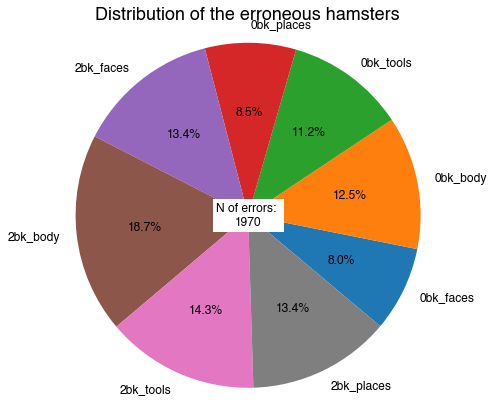

In [254]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
stims = ['0bk_faces', '0bk_body', '0bk_tools', '0bk_places'
        , '2bk_faces', '2bk_body', '2bk_tools', '2bk_places']

labels = stims 
sizes = all_phases
explode = (0, 0, 0, 0, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
plt.rcParams["font.family"] = 'Helvetica'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = [8, 7]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=-40)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of the erroneous hamsters', fontsize=18)
text_total_error = 'N of errors: \n{0}'.format(int(np.sum(all_phases)))
plt.text(0, 0, text_total_error, ha='center', va='center', bbox = dict(boxstyle='square', fc=(1,1,1), ec='None'))
plt.show()
fig1.savefig('./fig1', dpi=300)